## Imports

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

import tensorflow as tf
from keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0, DenseNet121
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import os
import time
import random

## Data loader

In [19]:
class DataLoader():
    """Data Loader class"""
    def __init__(self):
        super().__init__()
    
    def image_equalization(self, image):
        """Equalizes the histogram of an image"""
        # R, G, B = cv2.split(image)
        # output1_R = cv2.equalizeHist(R)
        # output1_G = cv2.equalizeHist(G)
        # output1_B = cv2.equalizeHist(B)
        # equ = cv2.merge((output1_R, output1_G, output1_B))
        return image

    def load_train_data(self, path):
        """Loads dataset from path"""
        self.train_datagen = ImageDataGenerator(
            rescale=1./255, 
            validation_split=0.1,
            preprocessing_function=None
            )
        return self.train_datagen.flow_from_directory(
        path,
        subset='training',
        target_size=(224, 224),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical')
        
    
    def load_val_data(self, path):
        """Loads dataset from path"""
        self.train_datagen = ImageDataGenerator(
            rescale=1./255, 
            validation_split=0.1,
            preprocessing_function=None)
        return self.train_datagen.flow_from_directory(
        path,
        subset='validation',
        target_size=(224, 224),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical')
    
    
    def load_test_data(self, path):
        """Loads dataset from path"""
        self.test_datagen = ImageDataGenerator(
            rescale=1./255,
            preprocessing_function=None)
        return self.test_datagen.flow_from_directory(
        path,
        target_size=(224, 224),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical')


# CNN Models

## Full Training

In [59]:
def dense_net_model_FT(input_shape, classes=7):
    """DenseNet model"""
    inputs = layers.Input(shape=input_shape)
    base_model = DenseNet121(
        input_shape=input_shape, include_top=True, weights=None, classes=classes
    )(inputs)
    return models.Model(inputs, base_model)


def vgg16_model_FT(input_shape, classes=7):
    """VGG16 model"""
    inputs = layers.Input(shape=input_shape)
    base_model = VGG16(
        input_shape=input_shape, include_top=True, weights=None, classes=classes
    )(inputs)
    return models.Model(inputs, base_model)


def efficient_net_model_FT(input_shape, classes=7):
    """EfficientNet model"""
    inputs = layers.Input(shape=input_shape)
    base_model = EfficientNetB0(
        input_shape=input_shape, include_top=True, weights=None, classes=classes
    )(inputs)
    return models.Model(inputs, base_model)


## Fine Tunning

In [64]:
def dense_net_model(input_shape, classes=7):
    """DenseNet model"""
    base_model = DenseNet121(
        input_shape=input_shape, include_top=False, weights='imagenet', classes=classes
    )
    base_model.trainable = False
    x = base_model.output

    # add a global spatial average pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # and a logistic layer
    predictions = layers.Dense(classes, activation="sigmoid")(x)
    return models.Model(base_model.input, predictions)


def vgg16_model(input_shape, classes=7):
    """VGG16 model"""
    base_model = VGG16(
        input_shape=input_shape, include_top=False, weights='imagenet', classes=classes
    )
    base_model.trainable = False
    x = base_model.output

    # add a global spatial average pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # and a logistic layer
    predictions = layers.Dense(classes, activation="sigmoid")(x)
    return models.Model(base_model.input, predictions)


def efficient_net_model(input_shape, classes=7):
    """EfficientNet model"""
    base_model = EfficientNetB0(
        input_shape=input_shape, include_top=False, weights='imagenet', classes=classes
    )
    base_model.trainable = False
    x = base_model.output

    # add a global spatial average pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # and a logistic layer
    predictions = layers.Dense(classes, activation="sigmoid")(x)
    return models.Model(base_model.input, predictions)


## Training

In [65]:
def main(model_name="dense_net"):
    data_loader = DataLoader()
    train_data = data_loader.load_train_data("../data/train/")
    val_data = data_loader.load_val_data("../data/train/")
    test_data = data_loader.load_test_data("../data/test/")
    
    if model_name == "vgg16":
        model = vgg16_model(
            input_shape=(224, 224, 3),
            classes=7,
        )
    elif model_name == "vgg16_ft":
        model = vgg16_model_FT(
            input_shape=(224, 224, 3),
            classes=7,
        )
    elif model_name == "efficient_net_ft":
        model = efficient_net_model_FT(
            input_shape=(224, 224, 3),
            classes=7,
        )
    elif model_name == "efficient_net":
        model = efficient_net_model(
            input_shape=(224, 224, 3),
            classes=7,
        )
    elif model_name == "dense_net_ft":
        model = dense_net_model_FT(
            input_shape=(224, 224, 3),
            classes=7,
        )
    elif model_name == "dense_net":
        model = dense_net_model(
            input_shape=(224, 224, 3),
            classes=7,
        )
    else:
        print("Please specify a valid model name")
        

    model.compile(
        optimizer='adamw',
        loss="categorical_crossentropy",
        metrics=["accuracy", "precision", "recall", "f1_score"]#cfg.train.metrics,
    )
    
    """Model callbacks"""
    earlystopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", mode="min", verbose=1, patience=5
    )
    checkpointer = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{model_name}.weights.h5",
        save_weights_only=True,
        save_best_only=True,
    )

    # Train the model

    history = model.fit(
        x=train_data,
        validation_data=val_data,
        epochs=50,
        batch_size=64,
        callbacks=[earlystopping, checkpointer],
    )

    # Evaluate the model
    #{str(time.time())}
    model.save(f"{model_name}_model.keras")
    test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(test_data)
    print(f"Test accuracy: {test_accuracy}")

    # Log the confusion matrix
    y_pred = model.predict(test_data)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = test_data.classes
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=test_data.class_indices
    )
    disp.plot(cmap="viridis", values_format="d")
    plt.xticks(rotation=90)
    plt.title("Confusion Matrix")
    plt.savefig(f"{model_name}_confusion_matrix.png")

    # Log the classification report
    class_names = [k for k, v in test_data.class_indices.items()]
    report = classification_report(
        y_true, y_pred, target_names=class_names, output_dict=True
    )
    report = {k: v for k, v in report.items() if k in class_names}
    report = {k: {k2: round(v2, 2) for k2, v2 in v.items()} for k, v in report.items()}
    report = {
        k: dict(sorted(v.items(), key=lambda item: item[1], reverse=True))
        for k, v in report.items()
    }
    report = {
        k: {k2: v2 for k2, v2 in v.items() if k2 != "support"}
        for k, v in report.items()
    }
    report = {
        k: {k2: v2 for k2, v2 in v.items() if k2 != "macro avg"}
        for k, v in report.items()
    }
    report = {
        k: {k2: v2 for k2, v2 in v.items() if k2 != "weighted avg"}
        for k, v in report.items()
    }
    _model_history(history, model_name)
    return report



def _model_history(model_info, model_name="dense_net"):
    accuracy = model_info.history["accuracy"]
    val_accuracy = model_info.history["val_accuracy"]
    loss = model_info.history["loss"]
    val_loss = model_info.history["val_loss"]
    precision = model_info.history["precision"]
    val_precision = model_info.history["val_precision"]
    recall = model_info.history["recall"]
    val_recall = model_info.history["val_recall"]
    f1_score = model_info.history["f1_score"]
    val_f1_score = model_info.history["val_f1_score"]
    epochs = range(1, len(accuracy) + 1)
    plt.figure(figsize=(20, 10))
    plt.plot(epochs, accuracy, "g-", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name}_accuracy.png", dpi=300, bbox_inches="tight")

    plt.figure(figsize=(20, 10))
    plt.plot(epochs, loss, "g-", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name}_loss.png", bbox_inches="tight", dpi=300)

    plt.figure(figsize=(20, 10))
    plt.plot(epochs, precision, "g-", label="Training precision")
    plt.plot(epochs, val_precision, "b", label="Validation precision")
    plt.title("Training and validation precision")
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name}_precision.png", bbox_inches="tight", dpi=300)

    plt.figure(figsize=(20, 10))
    plt.plot(epochs, recall, "g-", label="Training recall")
    plt.plot(epochs, val_recall, "b", label="Validation recall")
    plt.title("Training and validation recall")
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name}_recall.png", bbox_inches="tight", dpi=300)

    plt.figure(figsize=(20, 10))
    plt.plot(epochs, f1_score, "g-", label="Training f1_score")
    plt.plot(epochs, val_f1_score, "b", label="Validation f1_score")
    plt.title("Training and validation f1_score")
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name}_f1_score.png", bbox_inches="tight", dpi=300)
   
    plt.figure(figsize=(20, 10))
    plt.plot(epochs, f1_score, "g-", label="Training f1_score")
    plt.plot(epochs, val_f1_score, "b", label="Validation f1_score")
    plt.title("Training and validation f1_score")
    plt.legend()
    plt.grid()
    plt.savefig(f"{model_name}_f1_score_daft.png", bbox_inches="tight", dpi=300)

Found 6048 images belonging to 7 classes.
Found 672 images belonging to 7 classes.
Found 280 images belonging to 7 classes.
Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 817s 8s/step - accuracy: 0.3593 - f1_score: 0.3543 - loss: 1.6925 - precision: 0.2299 - recall: 0.7182 - val_accuracy: 0.7054 - val_f1_score: 0.7026 - val_loss: 0.8902 - val_precision: 0.4292 - val_recall: 0.9018
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 712s 7s/step - accuracy: 0.7438 - f1_score: 0.7417 - loss: 0.8163 - precision: 0.4350 - recall: 0.8991 - val_accuracy: 0.7902 - val_f1_score: 0.7891 - val_loss: 0.6829 - val_precision: 0.4877 - val_recall: 0.9122
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 704s 7s/step - accuracy: 0.8140 - f1_score: 0.8130 - loss: 0.6125 - precision: 0.5082 - recall: 0.9186 - val_accuracy: 0.8125 - val_f1_score: 0.8092 - val_loss: 0.5954 - val_precision: 0.5272 - val_recall: 0.8943
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 712s 7s/step - accuracy: 0.8505 - f1_score: 0.8486 - loss: 0.5068 - precision: 0.5440

5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.9045 - f1_score: 0.9055 - loss: 0.3558 - precision: 0.7020 - recall: 0.8933
Test accuracy: 0.9107142686843872
5/5 ━━━━━━━━━━━━━━━━━━━━ 51s 8s/step


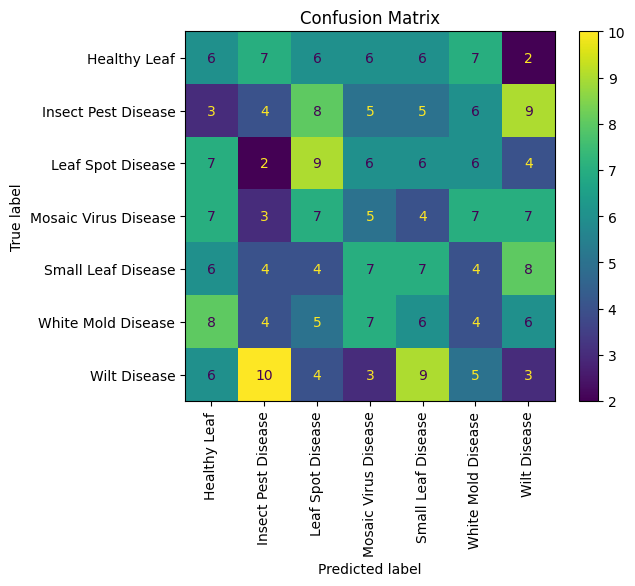

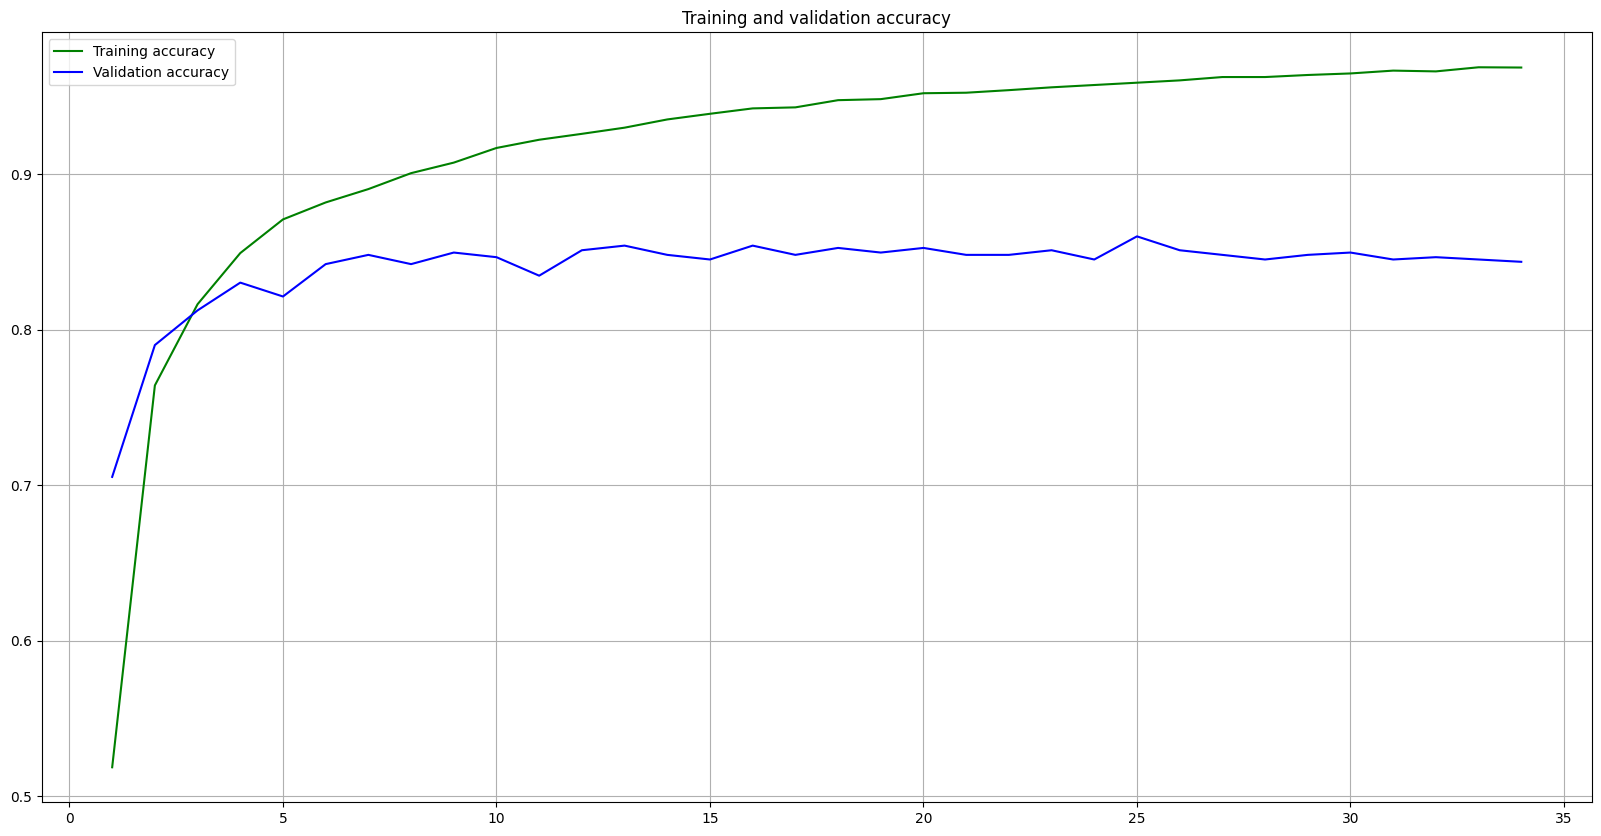

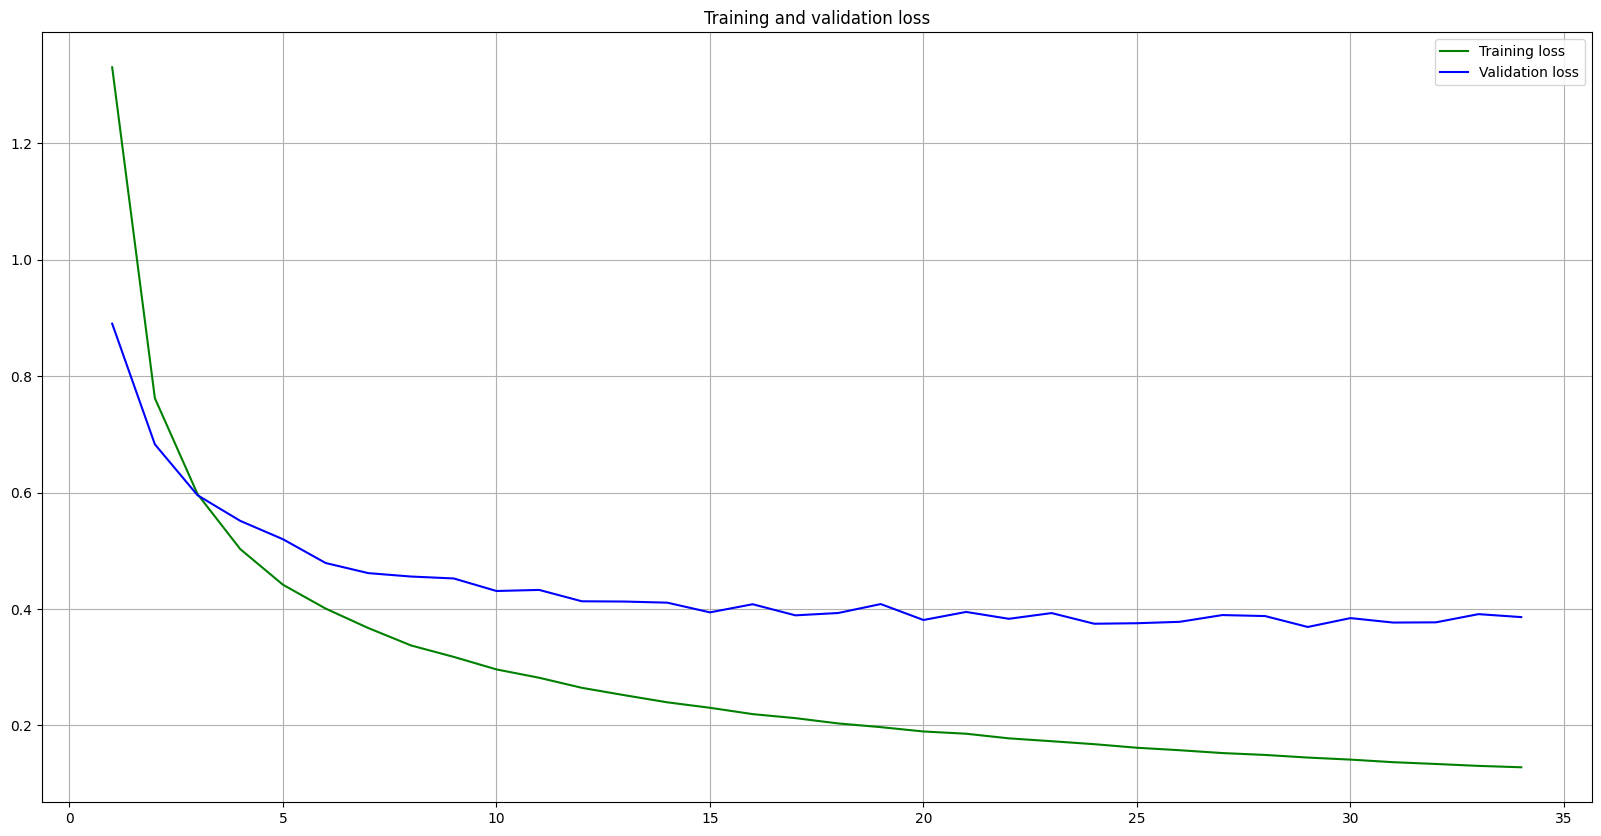

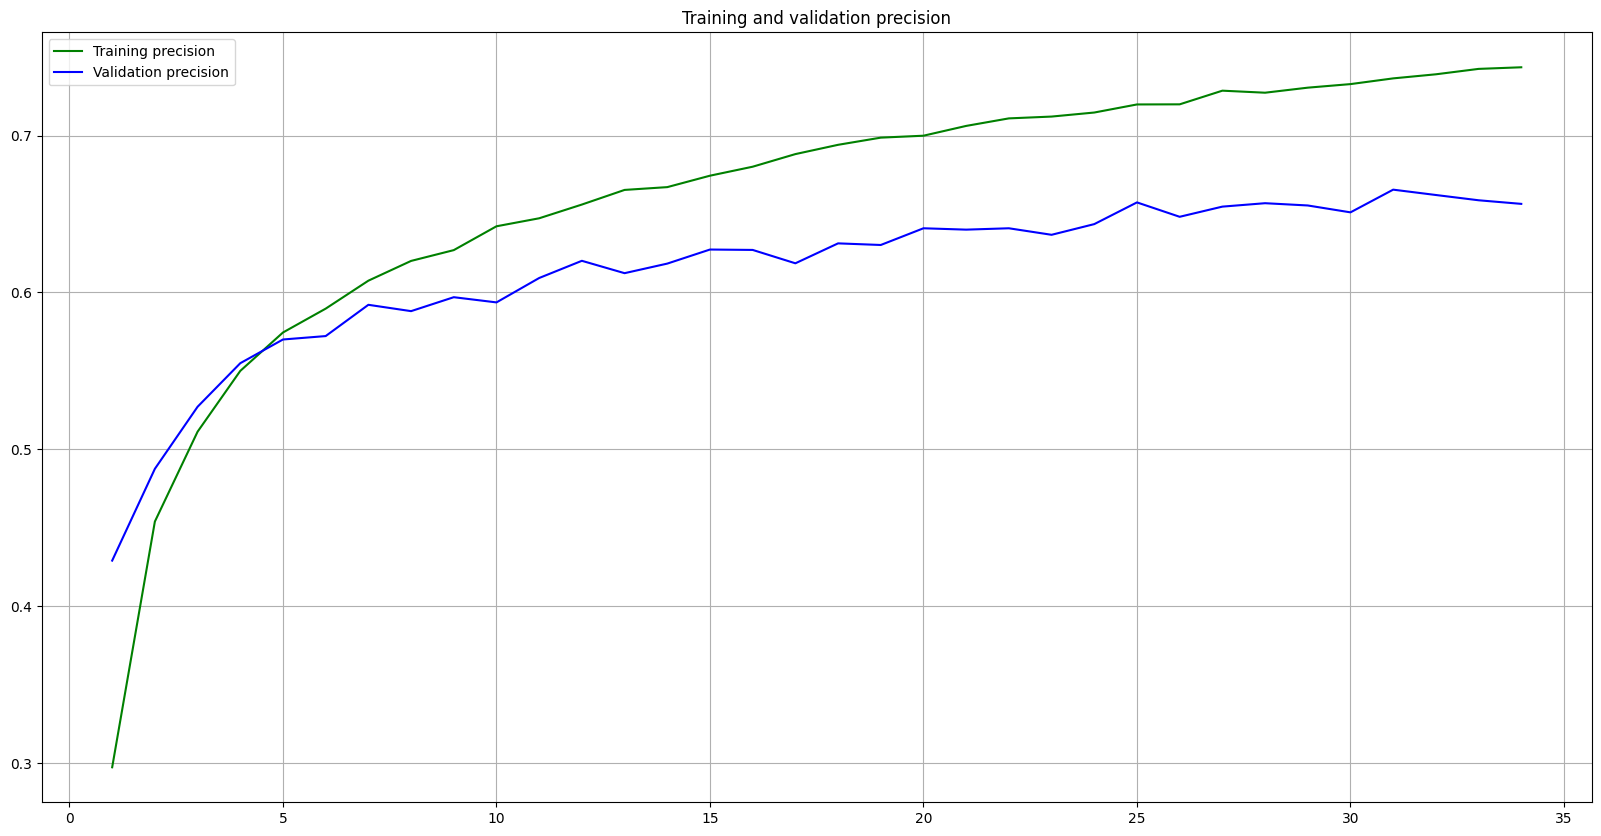

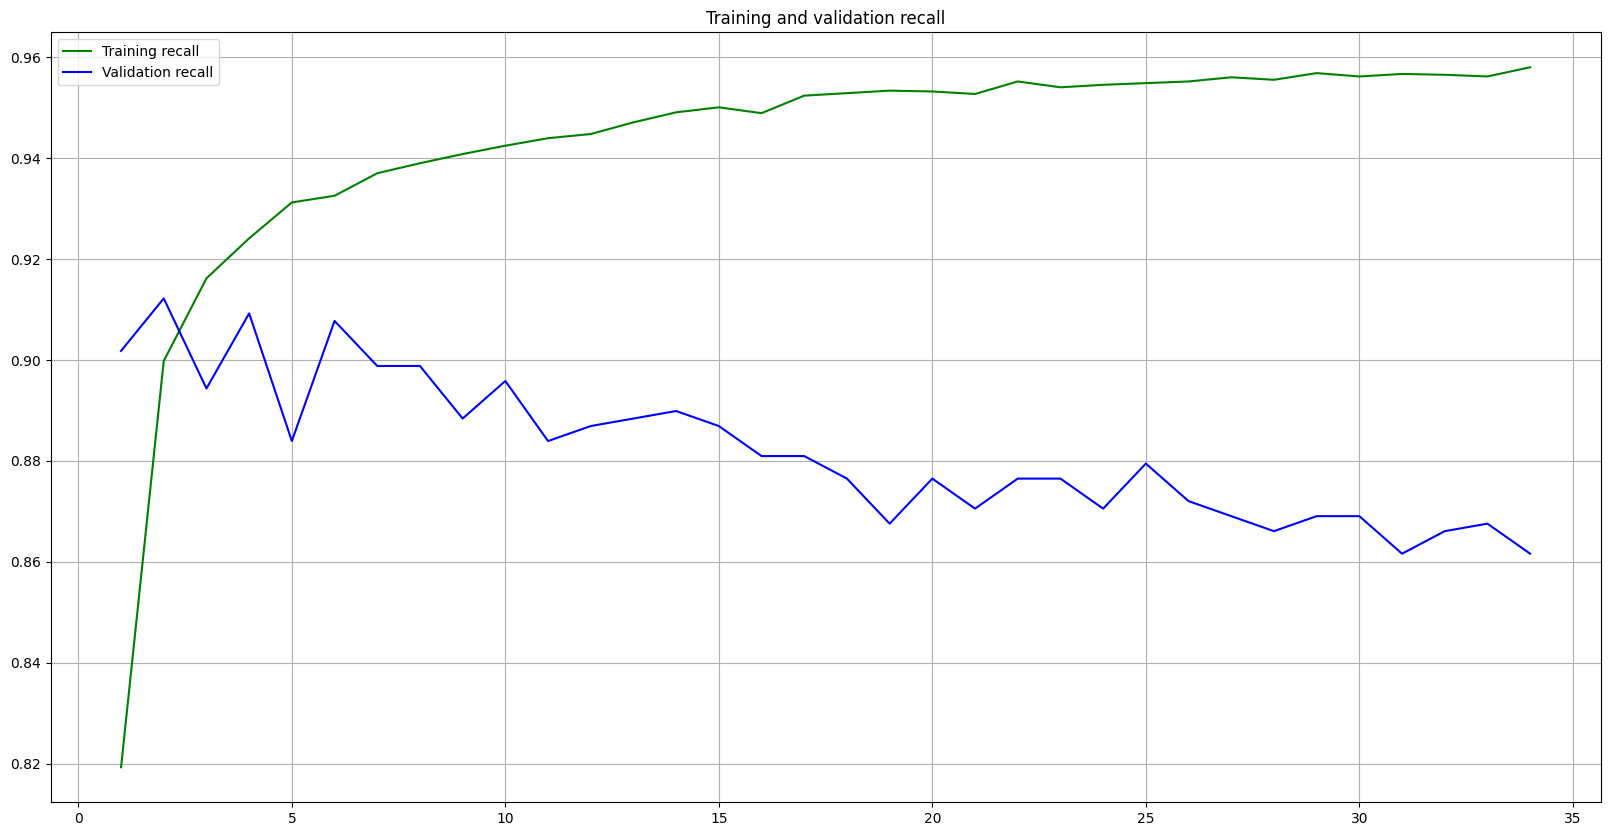

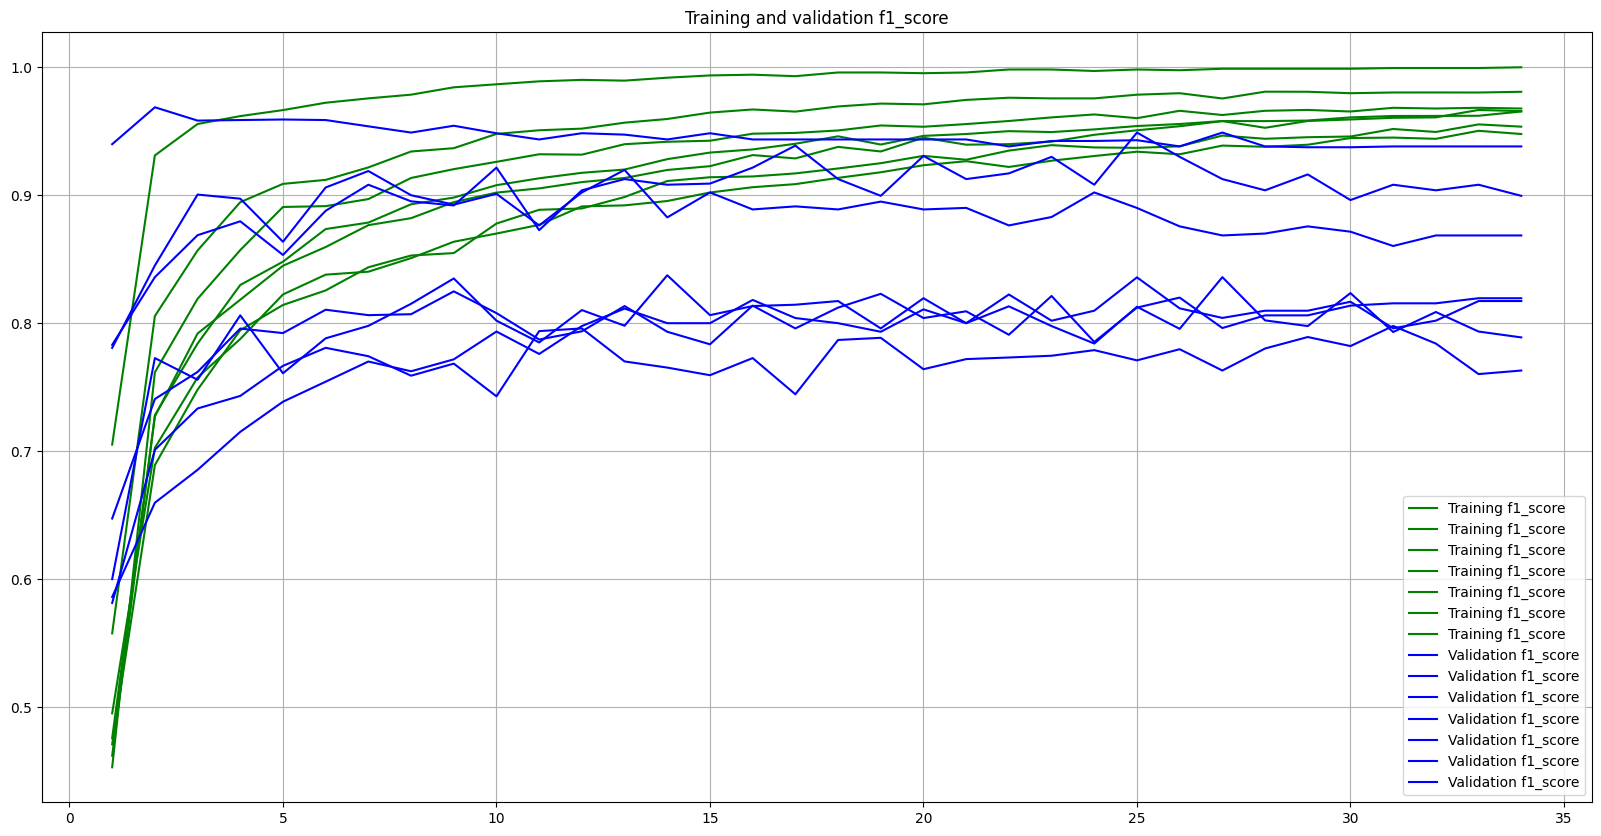

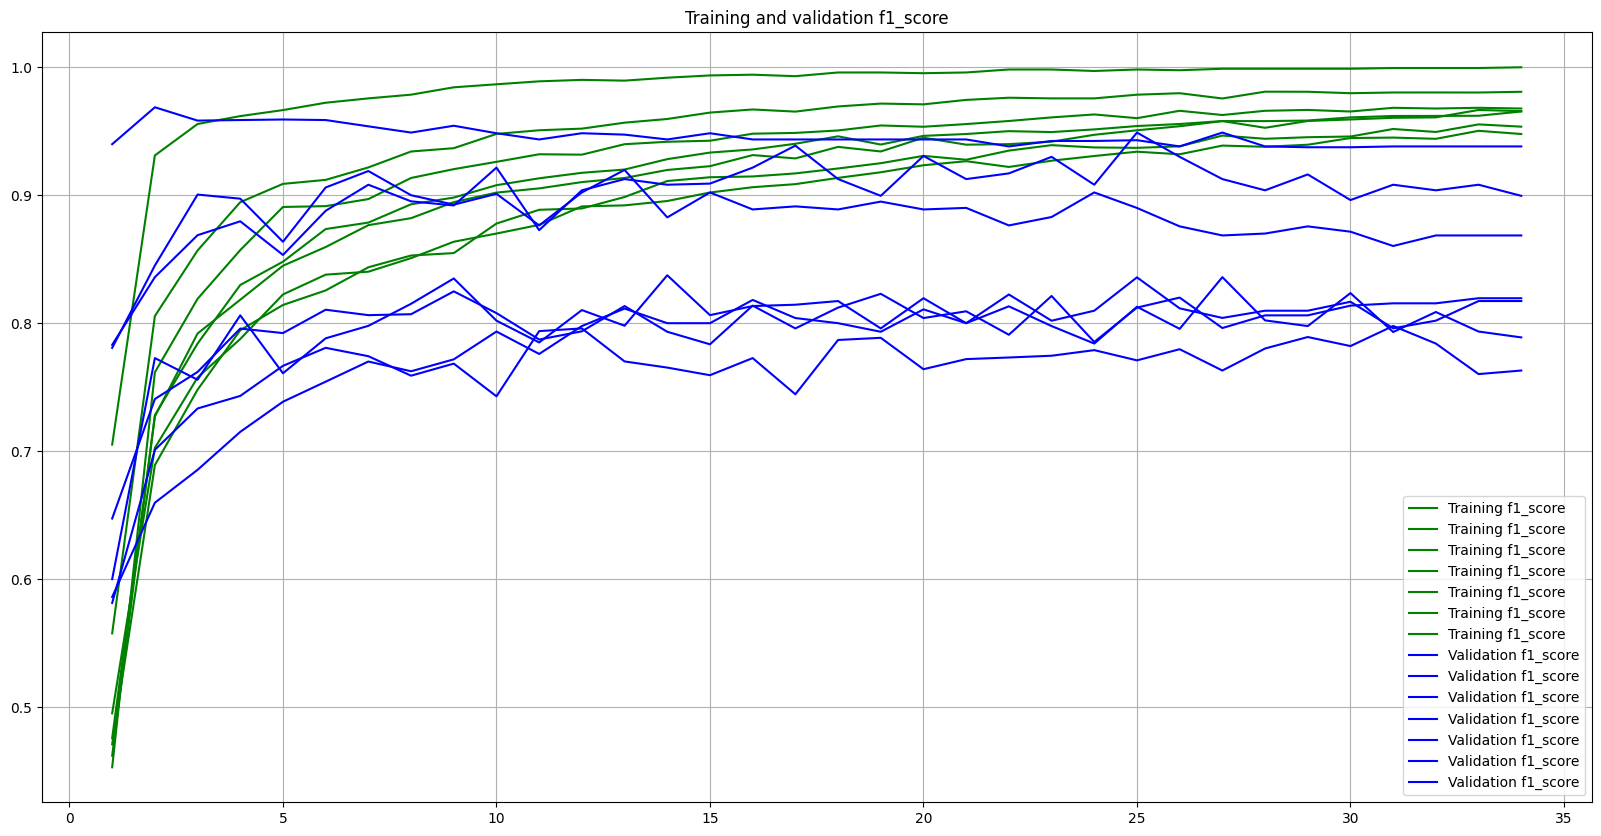

In [55]:
dense_net_report = main("dense_net")

In [56]:
dense_net_report

{'Healthy Leaf': {'recall': 0.15, 'precision': 0.14, 'f1-score': 0.14},
 'Insect Pest Disease': {'precision': 0.12, 'f1-score': 0.11, 'recall': 0.1},
 'Leaf Spot Disease': {'recall': 0.23, 'f1-score': 0.22, 'precision': 0.21},
 'Mosaic Virus Disease': {'precision': 0.13, 'f1-score': 0.13, 'recall': 0.12},
 'Small Leaf Disease': {'recall': 0.17, 'f1-score': 0.17, 'precision': 0.16},
 'White Mold Disease': {'precision': 0.1, 'recall': 0.1, 'f1-score': 0.1},
 'Wilt Disease': {'precision': 0.08, 'f1-score': 0.08, 'recall': 0.07}}

In [61]:
dense_net_report_FT = main("dense_net_ft")

Found 6048 images belonging to 7 classes.
Found 672 images belonging to 7 classes.
Found 280 images belonging to 7 classes.
Epoch 1/50


c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 3187s 31s/step - accuracy: 0.4022 - f1_score: 0.3972 - loss: 1.5695 - precision: 0.5728 - recall: 0.2120 - val_accuracy: 0.1354 - val_f1_score: 0.0437 - val_loss: 8.9324 - val_precision: 0.1415 - val_recall: 0.1339
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2882s 30s/step - accuracy: 0.5439 - f1_score: 0.5409 - loss: 1.1503 - precision: 0.7219 - recall: 0.3365 - val_accuracy: 0.1607 - val_f1_score: 0.0789 - val_loss: 8.1788 - val_precision: 0.1703 - val_recall: 0.1399
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2882s 30s/step - accuracy: 0.6113 - f1_score: 0.6085 - loss: 0.9971 - precision: 0.7303 - recall: 0.4528 - val_accuracy: 0.1696 - val_f1_score: 0.1360 - val_loss: 3.9627 - val_precision: 0.1843 - val_recall: 0.1503
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2883s 30s/step - accuracy: 0.6606 - f1_score: 0.6572 - loss: 0.8663 - precision: 0.7651 - recall: 0.5454 - val_accuracy: 0.2783 - val_f1_score: 0.1770 - val_loss: 3.3545 - val_precision: 0.2880 - val_recall: 0.2426

ValueError: Unable to create dataset (name already exists)

In [66]:
vgg_net_report = main("vgg16")

Found 6048 images belonging to 7 classes.
Found 672 images belonging to 7 classes.
Found 280 images belonging to 7 classes.


ValueError: If using `weights='imagenet'` with `include_top=True`, `classes` should be 1000.  Received classes=7

In [ ]:
vgg_net_report_FT = main("vgg16_ft")

In [ ]:
eff_net_report = main("efficient_net")

In [ ]:
eff_net_report_FT = main("efficient_net)ft")

# Vision Transformer

# Swin Transformer